In [69]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [70]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [71]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    return s

In [72]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('    ')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)

    return input_lang, output_lang, pairs

In [73]:
MAX_LENGTH = 10




def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH 



def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [75]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")

    for pair in pairs :
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])

    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)

    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'hin', False)
print(random.choice(pairs))
print(random.choice(pairs_test))

Reading lines...
Read 49999 sentence pairs
Trimmed to 4914 sentence pairs
Counting words...
Counted words:
hin 5602
eng 6317
['shivlinga is in jwaleshwar mahadev .', 'जवालश\u200dवर महादव मदिर म शिवलिग ह ।']
["every year magazine makes a questionnaire available online for it 's readers .", 'मगजीन अपन पाठको को हर साल एक परशनोततरी ऑनलाइन उपलबध कराती ह ।']


In [76]:
b = (int)(len(pairs)*0.8)
print(b)
print(len(pairs))
ads = 31199-24959
print(ads)
len(pairs[b:])

3931
4914
6240


983

In [77]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [78]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(2816, self.max_length)

        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):

        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        
        attn_weights = F.softmax(
            self.attn(torch.cat((encoder_outputs.view(1, encoder_outputs.shape[0]*encoder_outputs.shape[1]), hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [79]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [80]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [81]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [82]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    temp = (int)(len(pairs)*0.8)
    pairs_train = pairs[0:]
    training_pairs = [tensorsFromPair(random.choice(pairs_train))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [83]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [84]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [86]:
def evaluateRandomly(encoder, decoder):

    out_sent = []
    ref_sent = []
    temp = (int)(len(pairs)*0.8)
    pairs_test = pairs[temp:]
    for pair in pairs_test :

        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        out_sent.append(output_sentence)
        ref_sent.append(pair[1])
        
    return ref_sent, out_sent


2m 11s (- 85m 42s) (1000 2%) 5.4164
4m 26s (- 84m 26s) (2000 5%) 5.3574
6m 46s (- 83m 35s) (3000 7%) 5.2577
9m 2s (- 81m 20s) (4000 10%) 5.1000
11m 16s (- 78m 54s) (5000 12%) 5.0348
13m 29s (- 76m 28s) (6000 15%) 4.8579
15m 44s (- 74m 10s) (7000 17%) 4.7727
17m 59s (- 71m 59s) (8000 20%) 4.7069
20m 14s (- 69m 44s) (9000 22%) 4.5127
22m 28s (- 67m 25s) (10000 25%) 4.4689
24m 42s (- 65m 9s) (11000 27%) 4.3501
26m 58s (- 62m 55s) (12000 30%) 4.1769
29m 12s (- 60m 40s) (13000 32%) 4.1817
31m 27s (- 58m 26s) (14000 35%) 4.0972
33m 41s (- 56m 9s) (15000 37%) 3.9751
35m 59s (- 53m 59s) (16000 40%) 3.7896
38m 16s (- 51m 46s) (17000 42%) 3.7632
40m 31s (- 49m 31s) (18000 45%) 3.6844
42m 46s (- 47m 16s) (19000 47%) 3.6076
45m 1s (- 45m 1s) (20000 50%) 3.4769
47m 15s (- 42m 45s) (21000 52%) 3.2751
49m 30s (- 40m 30s) (22000 55%) 3.2838
51m 45s (- 38m 15s) (23000 57%) 3.2199
54m 1s (- 36m 1s) (24000 60%) 3.2473
56m 15s (- 33m 45s) (25000 62%) 3.0550
58m 30s (- 31m 30s) (26000 65%) 2.9621
60m 45s (

<Figure size 432x288 with 0 Axes>

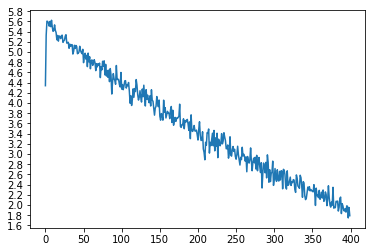

In [87]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 40000, print_every=1000)

In [88]:
ref_sent, out_sent = evaluateRandomly(encoder1, attn_decoder1)

In [89]:
for i in range(20) :
    print(ref_sent[i] + "     " + out_sent[i])
    print()

नहाकर आत ।     नहाकर आत ह । <EOS>

लट , बठ ।     इसक , , , । । <EOS>

सिर मढात ।     सिर को । । <EOS>

तरपण करत ।     उसकी को करना । <EOS>

खाना पकात ।     खाना । <EOS>

भजन करत ।     करत कर कर । <EOS>

साधओ क चरणो म लोट लगात ।     साधओ क चरणो म होन : । <EOS>

बिछडो को ढढत ।     बिछडो को । । <EOS>

रोत ।     उसक । <EOS>

कष‍टो की पोटली खोलत ।     अब की की की । <EOS>

लोग एक - दसर स टकरा रह ह ।     एक - स एक स ह ह । । <EOS>

उनका आपस म कोई रिशता नही ह ।     उनका कोई म कोई कोई नही ह । । <EOS>

एक सतर म जोड हए ह ।     एक म म म म ह ह । <EOS>

एक विराट दश बनाए हए ह ।     एक दश दश दश ह । <EOS>

यह भारत ह ।     यह भारत भारत ह । <EOS>

कया म भावक हो रहा ह ?     कया म म हो हो ह ह <EOS>

यह सच मर सामन ह ।     यह सामन सामन ह । । <EOS>

इलाहबाद भारत नही ह ।     इलाहबाद भारत नही ह । <EOS>

पर यह कभ भारत ह ।     यह भारत भारत ह । <EOS>

यह सिरफ भीड नही ह ।     यह एक नही नही । । <EOS>



In [101]:
with open('reference.txt','w') as f:
    for out in ref_sent :
        f.write(out+'\n')

        
            

In [94]:
print(len(ref_sent))

983


In [96]:
def evaluateRandomly1(encoder, decoder, n=10):
    temp = (int)(len(pairs)*0.8)
    pairs_test = pairs[temp:]
    for i in range(n):
        pair = random.choice(pairs_test)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [99]:
evaluateRandomly1(encoder1, attn_decoder1)

> 102 tunnels are in use among these .
= इनम स अब 102 सरग इसतमाल म ह ।
< इनम इनम स इनम म इसतमाल कर ह । <EOS>

> the land is very fertile .
= भमि बडी उपजाऊ ह ।
< भमि बडी उपजाऊ ह । <EOS>

> karauli is a historical place .
= करौली एक ऐतिहासिक शहर ह ।
< करौली एक ऐतिहासिक ह । <EOS>

> birth of krishna is celebrated with much fanfare .
= बडी धमधाम स कष‍णजनम मनाया जाता ह ।
< बडी बडी म मनाया मनाया जाता ह । <EOS>

> the national museum is situated at janpath .
= राष‍टरीय सगरहालय जनपथ पर सथित ह ।
< मसरी म पहाडी पर ह । । <EOS>

> it is called ' seesa ' mountain .
= इस ’ सीसा पहाड ’ कहा जाता ह ।
< इस ही पहाड पहाड कहा कहा ह । <EOS>

> but it was definitely not found deserted .
= मगर वह वीरान हरगिज न मिला ।
< मगर वह पर न न थ । । <EOS>

> island safari of phuket is very popular .
= फकत की आईलड सफारी काफी लोकपरिय ह ।
< गौडचन बहत बहत लोकपरिय लोकपरिय ह । <EOS>

> overall houses are concrete .
= कल मकान पकक ह ।
< कल मकान ह । <EOS>

> this meeting can be seen clearly .
= यह मिलन साफ दखा जा सकता ह ।
< यह य

In [104]:
%run bleu.py -t output.txt -r reference.txt

BLEU = 33.81, 559/10/327/10/283/10/126/5 (BP=1.0, ratio=1.132, hyp_len=8297, ref_len=7327)
